
# 회귀 분석 실습 노트북

이 노트북은 다중 회귀 분석 예제를 통해 데이터 시각화와 모델링 과정을 다룹니다.

## 목차
- [1. 데이터 불러오기 및 구조 확인](#1-데이터-불러오기-및-구조-확인)
- [2. 3D 산점도 시각화](#2-3d-산점도-시각화)
- [3. 입력/타깃 분리](#3-입력타깃-분리)
- [4. 모델 구성 및 컴파일](#4-모델-구성-및-컴파일)
- [5. 모델 구조 요약](#5-모델-구조-요약)
- [6. 모델 학습](#6-모델-학습)
- [7. 실제 vs 예측 시각화](#7-실제-vs-예측-시각화)
- [8. 손실 곡선 시각화](#8-손실-곡선-시각화)
- [9. 다중 샘플 예측](#9-다중-샘플-예측)
- [10. 단일 샘플 예측](#10-단일-샘플-예측)
- [11. 학습된 파라미터 확인](#11-학습된-파라미터-확인)
- [12. 예측 평면 계산](#12-예측-평면-계산)
- [13. 3D 결과 시각화(Matplotlib)](#13-3d-결과-시각화matplotlib)
- [14. 3D 결과 시각화(Plotly)](#14-3d-결과-시각화plotly)



### 1. 데이터 불러오기 및 구조 확인

인터넷에 공개된 회귀 분석 예제(`x09.txt`)를 불러와 샘플의 앞부분과 전체 shape을 확인합니다.


In [1]:

# 필수 라이브러리와 시각화 설정 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import koreanize_matplotlib

# 원본 데이터를 원격에서 불러와 배열 형태로 저장
raw_data = np.genfromtxt('https://people.sc.fsu.edu/~jburkardt/datasets/regression/x09.txt', skip_header=36)

print('샘플 데이터 (앞부분):')
print(raw_data[:5])
print('데이터 shape:', raw_data.shape)


2025-11-21 09:36:59.893882: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-21 09:37:00.431261: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-21 09:37:02.953565: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-21 09:37:02.953565: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


샘플 데이터 (앞부분):
[[  1.   1.  84.  46. 354.]
 [  2.   1.  73.  20. 190.]
 [  3.   1.  65.  52. 405.]
 [  4.   1.  70.  30. 263.]
 [  5.   1.  76.  57. 451.]]
데이터 shape: (25, 5)


In [2]:
# raw_data
raw_data[:,2]

array([84., 73., 65., 70., 76., 69., 63., 72., 79., 75., 27., 89., 65.,
       57., 59., 69., 60., 79., 75., 82., 59., 67., 85., 55., 63.])


### 2. 3D 산점도 시각화

체중, 나이, 혈중 지방 값을 각각 추출해 3차원 산점도로 표현하여 변수 간의 관계를 직관적으로 살펴봅니다.


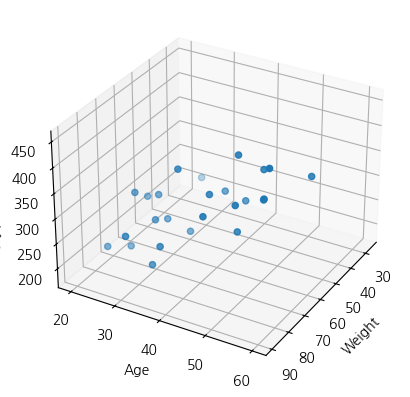

In [3]:

# 체중, 나이, 혈중 지방 열을 각각 추출하여 부동소수점 배열로 변환
xs = np.array(raw_data[:,2], dtype=np.float32)  # 체중
ys = np.array(raw_data[:,3], dtype=np.float32)  # 나이
zs = np.array(raw_data[:,4], dtype=np.float32)  # 혈중 지방

# 3차원 산점도 생성
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(xs, ys, zs)
ax.set_xlabel('Weight')
ax.set_ylabel('Age')
ax.set_zlabel('Blood fat')
ax.view_init(30, 30)  # 시점을 기울여 입체감 부여
plt.show()



### 3. 입력/타깃 분리

모델 학습에 사용할 입력(체중, 나이)과 타깃(혈중 지방) 데이터를 분리하고, 케라스가 기대하는 형태로 변환합니다.


In [4]:

# 입력(체중, 나이)과 타깃(혈중 지방) 분리
x_data = np.array(raw_data[:,2:4], dtype=np.float32)
y_data = np.array(raw_data[:,4], dtype=np.float32)

# 케라스 입력 형식에 맞게 타깃을 2차원으로 reshape
y_data = y_data.reshape(25, 1)

y_data


array([[354.],
       [190.],
       [405.],
       [263.],
       [451.],
       [302.],
       [288.],
       [385.],
       [402.],
       [365.],
       [209.],
       [290.],
       [346.],
       [254.],
       [395.],
       [434.],
       [220.],
       [374.],
       [308.],
       [220.],
       [311.],
       [181.],
       [274.],
       [303.],
       [244.]], dtype=float32)


### 4. 모델 구성 및 컴파일

두 개의 입력을 받아 혈중 지방을 예측하는 단층 선형 회귀 모델을 정의하고, RMSprop과 MSE로 최적화 설정을 합니다.


In [5]:

# 입력 2차원, 출력 1차원의 단층 선형 회귀 모델 정의
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1, input_shape=(2,)),
])

# 최적화 알고리즘과 손실 함수를 설정
model.compile(optimizer="rmsprop", loss="mse")


/home/jm/venv/tf_env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1763685424.068378    4555 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1763685424.081784    4555 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
W0000 00:00:1763685424.081784    4555 gpu_device.cc:2342] 


### 5. 모델 구조 요약

층 구성과 파라미터 개수를 확인하여 모델이 의도대로 설정되었는지 검증합니다.


In [6]:

# 모델 아키텍처 출력
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)


### 6. 모델 학습

5000 에포크 동안 학습을 진행해 손실이 충분히 수렴하도록 합니다.


In [7]:

# 충분히 수렴하도록 5000 에포크까지 학습
hist = model.fit(x_data, y_data, epochs=5000)


Epoch 1/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - loss: 60918.9414
Epoch 2/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 60751.8281
Epoch 3/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 60630.8203
Epoch 4/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 60529.6484
Epoch 5/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 60439.9414
Epoch 6/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 60357.8086
Epoch 7/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 60281.1016
Epoch 8/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 60208.4648
Epoch 9/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 60139.0000
Epoch 10/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 60072.0742
Epoch 11/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 60007.2148
Epoch 12/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 59944.0664
Epoch 13/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 59882.3555
Epoch 14/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 59821.8711
Epoch 15/5000



### 7. 실제 vs 예측 시각화

학습 데이터에 대한 실제 값과 예측 값을 비교하여 회귀 결과를 시각화합니다.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


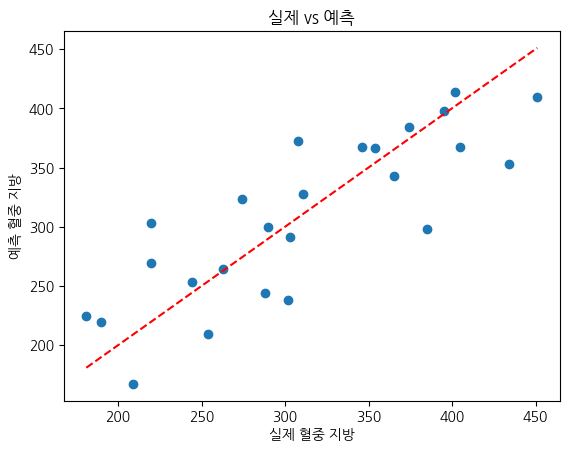

In [8]:

# 학습 데이터에 대한 예측값 계산
y_pred = model.predict(x_data)

# 실제-예측 산점도와 대각선 비교선 그리기
plt.scatter(y_data, y_pred)
plt.xlabel('실제 혈중 지방')
plt.ylabel('예측 혈중 지방')
plt.title('실제 vs 예측')
plt.plot([y_data.min(), y_data.max()], [y_data.min(), y_data.max()], 'r--')
plt.show()



### 8. 손실 곡선 시각화

에포크에 따른 손실 값 변화를 확인하여 학습 추이를 파악합니다.


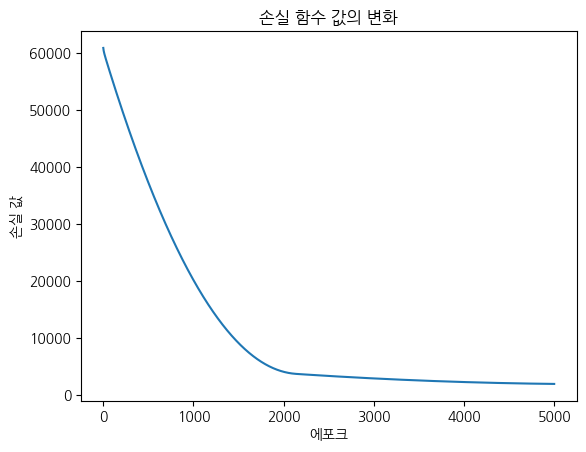

In [9]:

# 학습 과정의 손실 값 추이 시각화
plt.plot(hist.history['loss'])
plt.title('손실 함수 값의 변화')
plt.xlabel('에포크')
plt.ylabel('손실 값')
plt.show()



### 9. 다중 샘플 예측

여러 체중/나이 조합에 대해 모델이 예측한 혈중 지방 값을 확인합니다.


In [10]:

# 임의의 체중/나이 조합에 대해 혈중 지방 예측
model.predict(np.array([[70, 25], [80, 40], [60, 50]], dtype=np.float32))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


array([[239.71451],
       [330.4188 ],
       [349.1015 ]], dtype=float32)


### 10. 단일 샘플 예측

배치 차원을 포함하도록 reshape한 뒤 단일 샘플 예측 결과를 확인합니다.


In [11]:

# 단일 샘플 예측 (reshape로 배치 차원 추가)
model.predict(np.array([80, 56]).reshape(1,2))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


array([[410.4553]], dtype=float32)


### 11. 학습된 파라미터 확인

훈련된 가중치와 편향을 출력하여 학습 결과를 수치로 살펴봅니다.


In [12]:

# 학습된 가중치와 편향을 확인
W_, b_ = model.get_weights()
print("Weight is : ", W_)
print("bias is : ", b_)


Weight is :  [[1.5670056]
 [5.0022817]]
bias is :  [4.9670787]



### 12. 예측 평면 계산

체중과 나이에 대한 격자 포인트를 생성하고, 학습된 가중치를 사용해 예측 평면을 계산합니다.


In [13]:

# 예측 평면을 위해 체중과 나이의 격자 포인트 생성
x = np.linspace(20, 100, 50).reshape(50,1)
y = np.linspace(10, 70, 50).reshape(50,1)

# (50,2) 입력 배열을 구성하고 예측 평면 계산
X = np.concatenate((x, y), axis=1)
Z = np.matmul(X, W_) + b_



### 13. 3D 결과 시각화(Matplotlib)

실제 데이터와 예측 평면을 하나의 3D 그래프에 표시하여 회귀 결과를 직관적으로 확인합니다.


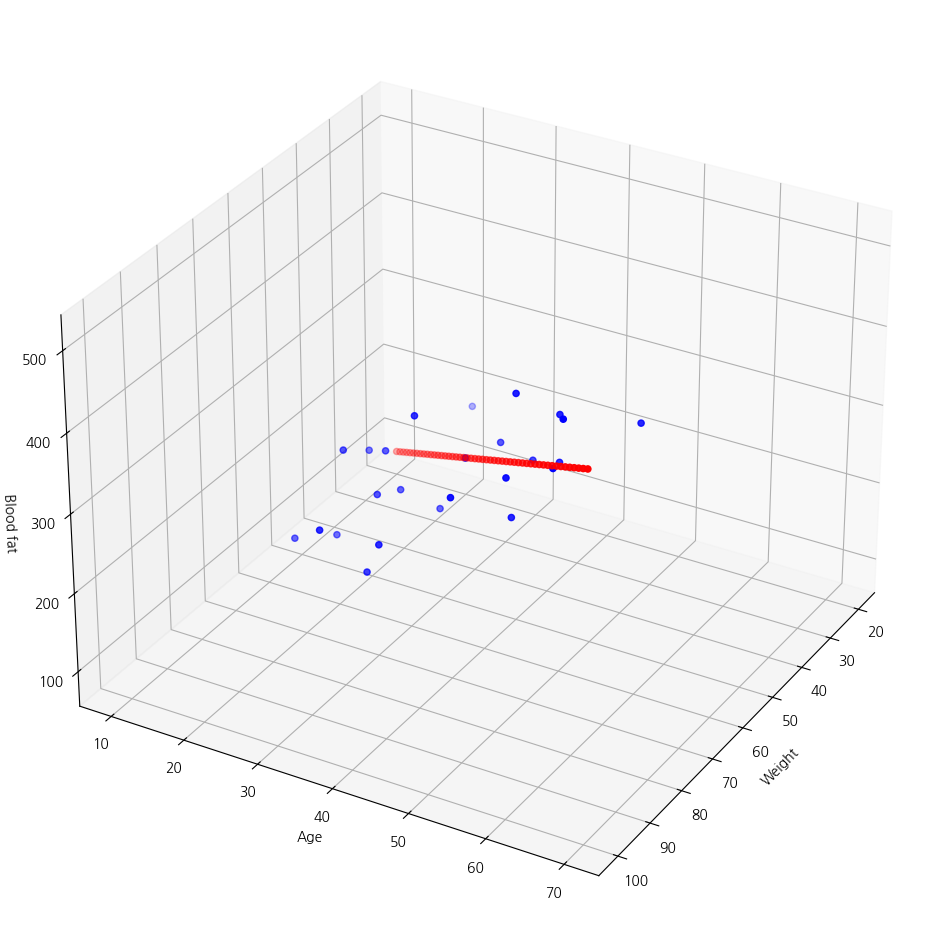

In [14]:

# 실제 데이터와 예측 평면을 하나의 3D 그래프로 시각화
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs, color='b', label='실제 데이터')
ax.scatter(x, y, Z, color='r', label='예측 평면')
ax.set_xlabel('Weight')
ax.set_ylabel('Age')
ax.set_zlabel('Blood fat')
ax.view_init(30, 30)
plt.show()



### 14. 3D 결과 시각화(Plotly)

인터랙티브 3D 그래프를 통해 실제 데이터와 예측 평면을 보다 자유롭게 탐색합니다.


In [15]:

import plotly.graph_objects as go

# 실제 데이터 산점도
scatter = go.Scatter3d(
    x=xs, y=ys, z=zs,
    mode='markers',
    marker=dict(size=5, color='blue'),
    name='실제 데이터'
)

# 예측 평면을 격자 포인트 형태로 표시
surface = go.Scatter3d(
    x=x.flatten(), y=y.flatten(), z=Z.flatten(),
    mode='markers',
    marker=dict(size=3, color='red'),
    name='예측 평면'
)

# 인터랙티브 시각화 생성
fig = go.Figure(data=[scatter, surface])
fig.update_layout(
    scene=dict(
        xaxis_title='Weight',
        yaxis_title='Age',
        zaxis_title='Blood fat'
    ),
    title='3D 회귀 결과 (인터랙티브)'
)
fig.show()
